In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("harjoitustyondata.csv", sep=";")
# Turning time into a datetime object
df['Aika'] = pd.to_datetime(df['Aika'], format='%d.%m.%Y %H:%M')

# Getting information about students
students = df.Pisteet.unique()
max_score =  max(students)
print(len(students), min(students), max(students))
course_start = df['Aika'].min()
course_end = df['Aika'].max()
print(course_start, course_end)

# To make things easier, let's collect the students into a dictionary, 
# where the points are the key to a list of all the student's timestamps
student_dict = {}
for student in students:
    student_info = df.loc[df['Pisteet'] == student]
    timestamp_list = student_info['Aika'].tolist()
    student_dict[student] = timestamp_list

score_student_mapping = {score: f"{idx+1}" for idx, score in enumerate(df['Pisteet'].unique())}
df['student_id'] = df['Pisteet'].map(score_student_mapping)

150 1055 7594
2019-08-07 10:15:00 2020-01-29 14:11:00


Above we are sorting the data. The data is first turned into a Pandas DataFrame.
In the dataset, we have 150 different students, whose score range from 1055 points to 7594 points.
The first entry was 7.8.2019 and the last 29.1.2020, so we are assuming this is the duration of the course. 
This would mean that the course was active for about 6 months. 

Below we can see that the point distribution is a bit unusual. Most of the students collected very high scores. The median value is 6945, marked red in the graph below.

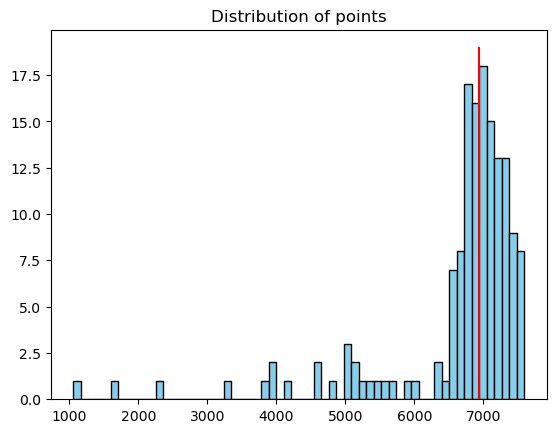

In [2]:
import statistics

median = statistics.median(students)

plt.hist(students, bins=60, color='skyblue', edgecolor='black')
plt.title('Distribution of points')
plt.vlines(x=median, ymin=0, ymax=19, color="red")
plt.show()

Based on this (and what G has done below), we can roughly divide the scores into three categories: 

* score < 6500
* 6500 < score < 7000
* score > 7000

Let's do some digging with the data, and see if we can come up with some rules(_or classifications? what they called_) for the decision tree thingaling 


# Hypothesis
- more active days &rarr; better score
- more logs &rarr; better score
- being consistently active &rarr; better score
- maybe the time of day spent working on the course has an effect on grades?



In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
# The time each student took to complete the course, rounded down
times = [(max(student_dict[s]) - min(student_dict[s])).total_seconds() / (60*60*24) + 1 for s in students]

# The number of different timestamps, i.e. the number of logs in total done by the student
logs = [len(student_dict[s]) for s in students]

# Finding out on how many different days a student worked on the course
dates = []
all_working_hours = [] #  time of day student tends to work, morning/day/night
pref_work_time = [] # 0 = morning, 1 = day, 2 = night
for s in students:  
    # Taking just the dates from timestamps, 
    # turning them into strings and to get only the unique values, turn the list into set
    uniq_dates = set([ str(d.date()) for d in student_dict[s]])
    # Append it as a list, 
    dates.append(len(uniq_dates)) 
    
    # Take the hour of the timesstamps and log it (morning: 6-12, day: 12-19, night: rest of the time)
    morning, day, night = 0, 0, 0
    hours = [(d.time().hour) for d in student_dict[s]]
    for hour in hours:
        if hour >= 6 and hour < 12:
            morning = morning + 1
        elif hour >= 12 and hour < 19:
            day = day + 1
        else: 
            night = night + 1
    # Here just collecting the data
    l = [morning, day, night]
    all_working_hours.append(l)
    # Finding out which index is the biggest to find out when student works the most
    # This is very inelegant, could be done better but let's see if there's something to it.
    m = max(l)
    pref_work_time.append(l.index(m))



In [4]:
# Here's a new dataframe for seaborn plotting.
# logs means the amount of logs,
# comp_t means the difference between last and first log, i.e. the course completion time
# log_days is the amount of days that logging has been done
# pref_work_t is the time of the day (morning, day, night) student has most time stamp logs
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time }
df_new = pd.DataFrame(data)

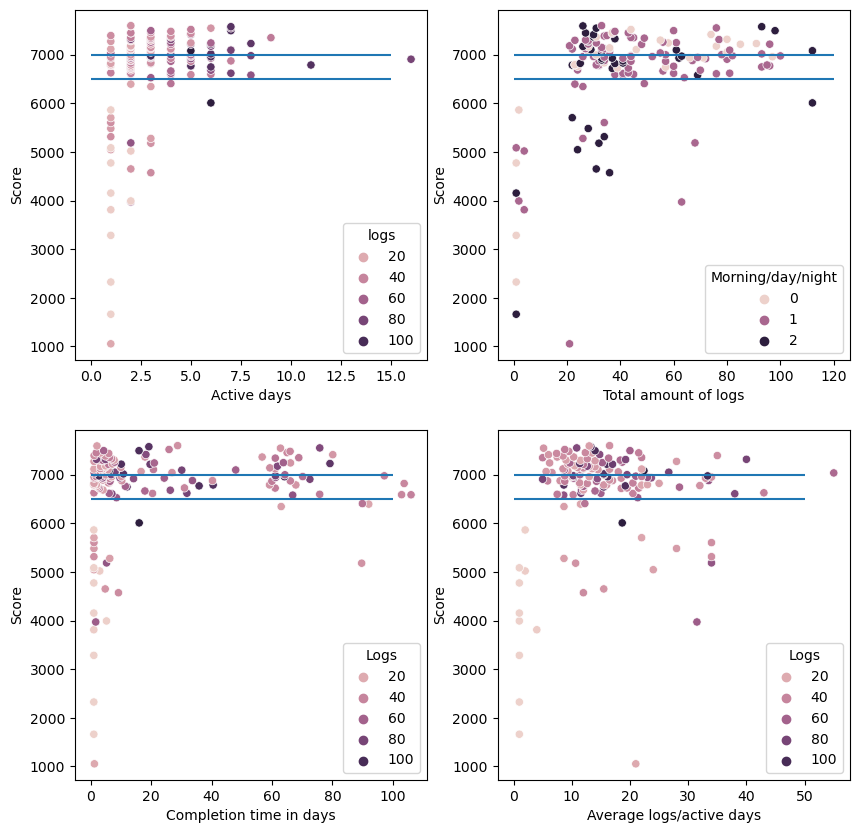

In [5]:
# Actual plotting 
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

times_arr = np.array(times) # course completion time
logs_arr = np.array(logs) # amount of logs
students_arr = np.array(students) # scores
dates_arr = np.array(dates) # active days

# for regression models
time_slope, time_intercept = np.polyfit(times_arr, students_arr, 1)
logs_slope, logs_intercept = np.polyfit(logs_arr, students_arr, 1)
dates_slope, dates_intercept = np.polyfit(dates_arr, students_arr, 1)

# Graph on top left
sns.scatterplot(x=dates_arr,
                y="score",
                hue="logs",
                ax=ax1,
                data=df_new)
ax1.hlines(y=6500, xmin=0, xmax=15)
ax1.hlines(y=7000, xmin=0, xmax=15)
ax1.set_xlabel('Active days')
ax1.set_ylabel('Score')

# Top right
sns.scatterplot(x="logs",
                    y="score",
                    hue="pref_work_t",
                    ax=ax2,
                    data=df_new)
ax2.hlines(y=6500, xmin=0, xmax=120)
ax2.hlines(y=7000, xmin=0, xmax=120)
ax2.set_ylabel('Score')
ax2.set_xlabel('Total amount of logs')
ax2.legend(title='Morning/day/night')


sns.scatterplot(x=times_arr,
                    y="score",
                    hue="logs",
                    ax=ax3,
                    data=df_new)
                    #, palette="Blues")
ax3.hlines(y=6500, xmin=0, xmax=100)
ax3.hlines(y=7000, xmin=0, xmax=100)
ax3.set_xlabel('Completion time in days')
ax3.set_ylabel('Score')
ax3.legend(title='Logs')
    
sns.scatterplot(x=logs_arr/dates_arr,
                    y="score",
                    hue="logs",
                    ax=ax4,
                    data=df_new)
                    #, palette="Blues")

ax4.hlines(y=6500, xmin=0, xmax=50)
ax4.hlines(y=7000, xmin=0, xmax=50)
ax4.set_xlabel('Average logs/active days')
ax4.set_ylabel('Score')
ax4.legend(title='Logs')

plt.show()

# Things to input into the decision tree

Above on the top left we can see that most of the students got very high points, a lot of them in a relatively short time interval. Below some general rules
 * 4 or more active days &rarr; score at least 6500

On the top right, we can see that the amount of logs can vary a lot for the grade. More logs does not necessarily equal better grade. There is distinctin by color, 0 means students logs were mostly mornings, 1 means during daytime and 2 means during night. 
 * 20 logs or less &rarr; score below 6500
 * working mostly on mornings &rarr; score above 6500 (maybe even above 7000)

Bottom left we can see that almost all of the students completed the course with less than 10 days activity logged. If you put in more work, you will likely get a good score. 
* course completion time at least 20 days &rarr; grade probably above 6500
* lots of logs (80-100) &rarr; grade probably over 7000

Bottom right: average amount of logs per active days. 

Add to the database:
 * active days
 * preferred working time
 * amount of logs

Now, let's extract for each student ID: the score, the number of clicks that I have for each student and put all in a new dataset

In [6]:
student_stats = df.groupby('student_id').agg(
    n_recordings=('Aika', 'count'),
    score=('Pisteet', 'first')
    ).reset_index()

student_stats = student_stats.rename(columns={'student_id': 'student_id', 'n_recordings': 'num_recordings', 'score': 'score'})

print(student_stats)

    student_id  num_recordings  score
0            1              21   1055
1           10              31   4649
2          100              46   7103
3          101              33   7110
4          102              22   7113
..         ...             ...    ...
145         95              28   7070
146         96             112   7078
147         97              61   7094
148         98              81   7090
149         99              29   7100

[150 rows x 3 columns]


We can define the classes for the score, chosen in a way that each class has a relevant number of entries.

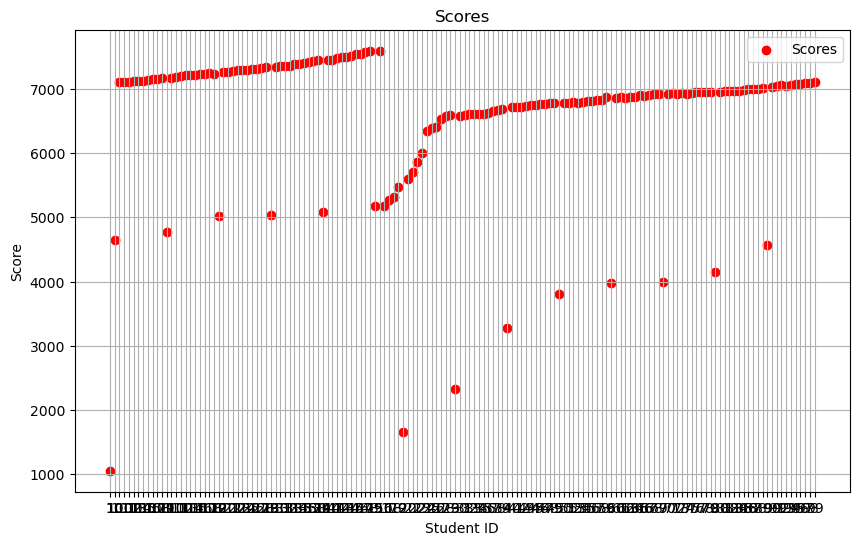

In [7]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['student_id'], student_stats['score'], color='red', label='Scores')

plt.title('Scores')
plt.xlabel('Student ID')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


We can divide the scores in 3 categories:

* score < 6500
* 6500 < score < 7000
* score > 7000

In [8]:
print(student_stats[student_stats['score'] < 6500]['student_id'].nunique())
print(student_stats[(student_stats['score'] >= 6500) & (student_stats['score'] <= 7000)]['student_id'].nunique())
print(student_stats[student_stats['score'] > 7000]['student_id'].nunique())

26
62
62


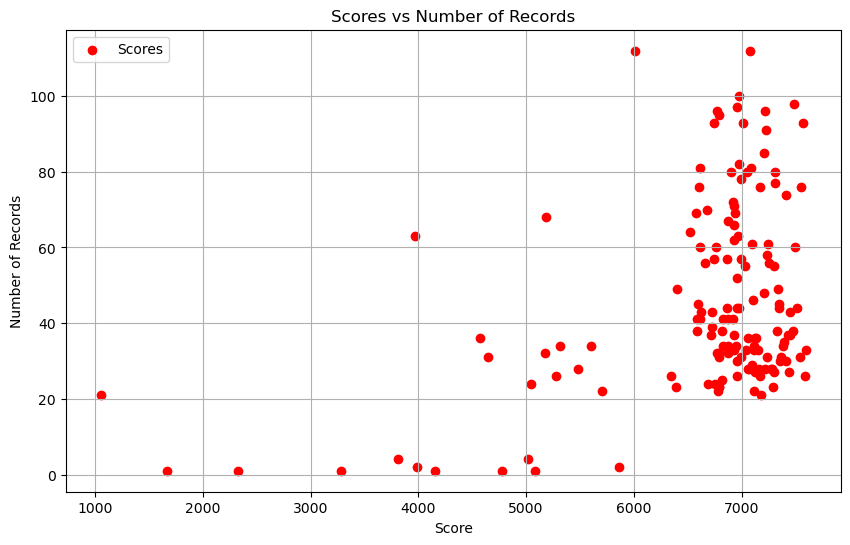

In [9]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['score'], student_stats['num_recordings'], color='red', label='Scores')

plt.title('Scores vs Number of Records')
plt.xlabel('Score')
plt.ylabel('Number of Records')
plt.legend()
plt.grid(True)
plt.show()

Now, we want to predict the score class based on the number of clicks and the mean click time. In a decision tree, each node tells to which sub tree the input sample should move until the sub tree is only the leaf node that corresponds to some class.

In [24]:
# The following is done based on the information found on the page
# https://www.datacamp.com/tutorial/decision-tree-classification-python 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# print(df_new) # Using this for starters with the decision tree

# Need to adjust the scoring category --> divide it to three
# score less than 6500 --> 0
# score between 6500 and 7000 --> 1
# score above 7000 --> 2
def categorize(x):
    if x < 6500:
        return 0
    elif x >= 7000:
        return 2
    else:
        return 1

# Trying another way of categorizing, maybe will get better results?
def categorize_alternative(x):
    if x < max_score * 0.5: # rough estimate, below this the grade is 0
        return 0
    elif x >= max_score * 0.9: # this would be a good grade
        return 5
    elif x >= max_score * 0.8:
        return 4
    elif x >= max_score * 0.7:
        return 3
    elif x >= max_score * 0.6:
        return 2
    else:
        return 1 

# The grade based estimation is more precise than the divide into three same size units
# Here adding a new column for the score estimation categories
df_new['score_category'] = df_new['score'].apply(categorize_alternative)
# df_new['score_category'] = df_new['score'].apply(categorize)

print(df_new)

#split dataset in features and target variable
feature_cols = ['logs', 'comp_t', 'log_days', 'pref_work_t' ]
X = df_new[feature_cols] # Features
y = df_new.score_category # Target variable

# Split dataset into training set and test set
# 75% training, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

max_leaf_nodes = 10
min_sample_leaf = 10
max_depth = 4  # Keeping the depth small seems to lead to better results

clf = DecisionTreeClassifier(criterion="gini", 
                             max_leaf_nodes = max_leaf_nodes,
                             min_samples_leaf = min_sample_leaf, 
                             max_depth= max_depth)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# TODO: Still should visualize maybe


     score  logs     comp_t  log_days  pref_work_t  score_category
0     1055    21   1.195139         1            1               0
1     1663     1   1.000000         1            2               0
2     2325     1   1.000000         1            0               0
3     3284     1   1.000000         1            0               0
4     3810     4   1.000000         1            1               1
..     ...   ...        ...       ...          ...             ...
145   7542    31  62.803472         6            2               5
146   7547    76  75.817361         7            1               5
147   7572    93  19.234028         7            2               5
148   7588    26   2.040972         2            2               5
149   7594    33  28.756944         2            1               5

[150 rows x 6 columns]
Accuracy: 0.5


In [11]:
!pip install pydotplus

In [21]:
!pip install pydotplus
conda install graphviz
# Might have to go to your environment variables and add the graphviz binaries directory there. Not sure how your system is 
# configured, hope it works :D Remember to restart the kernel, that tripped me up

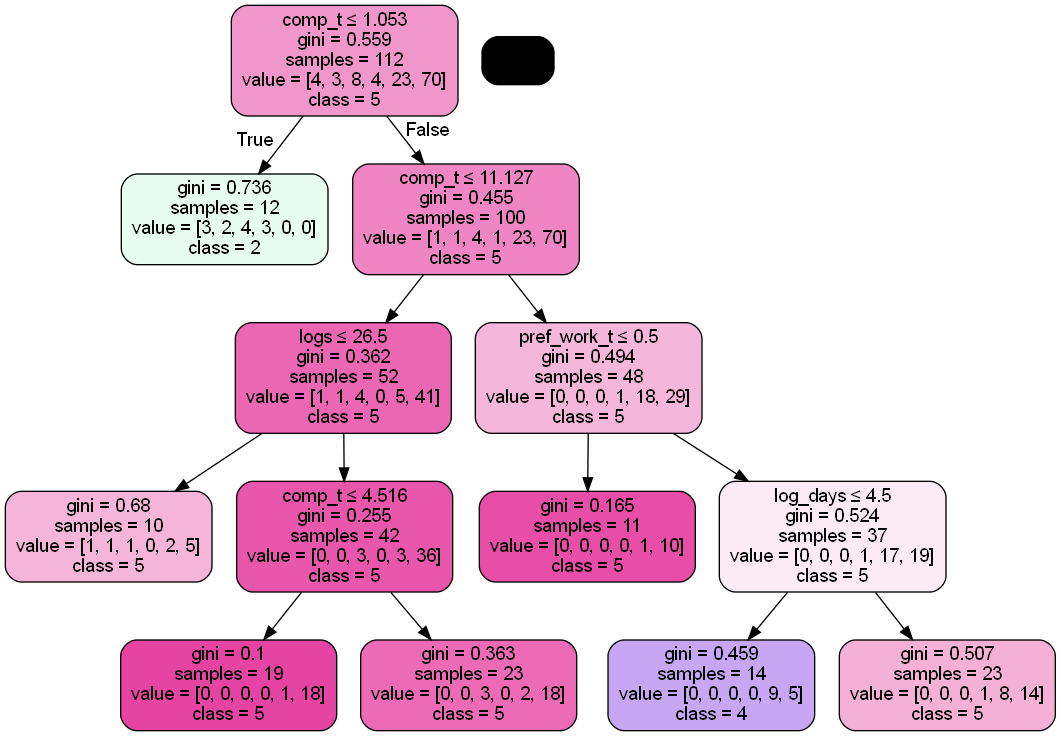

In [25]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1', '2', '3', '4', '5'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())